In [1]:
from pathlib import Path
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# https://jfly.uni-koeln.de/color/
# https://nanx.me/oneclust/reference/cud.html
named_colors = {
    "black": "#000000",
    "orange": "#e69f00",
    "skyblue": "#56b4e9",
    "bluish green": "#009e73",
    "yellow": "#f0e442",
    "blue": "#0072b2",
    "vermilion": "#d55e00",
    "reddish purple": "#cc79a7",
}
cud_palette = list(named_colors.values())
sns.set_theme(style="whitegrid")

def cud(n: int = len(cud_palette), start: int = 0) -> list[str]:
    remainder = cud_palette[:start]
    palette = cud_palette[start:] + remainder
    return palette[:n]

In [3]:
frames = []
modes = ["simplex", "duplex"]
models = ["fast", "hac", "sup"]
for mode in modes:
    for model in models:
        if model == "fast" and mode == "duplex":
            continue
        path = Path(f"../results/QC/stats/prefilter/{mode}/v4.3.0/dna_r10.4.1_e8.2_400bps_{model}@v4.3.0.csv")
        df = pd.read_csv(path)
        df["mode"] = mode
        df["model"] = model
        frames.append(df)

In [4]:
df = pd.concat(frames)
# rename filename column to sample
df.rename(columns={"filename": "sample"}, inplace=True)
# make the mode and model columns the first and second columns
col = df.pop("model")
df.insert(0, col.name, col)
col = df.pop("mode")
df.insert(0, col.name, col)
df.head()

,mode,model,sample,num_alignments,percent_total_reads,yield_gb,mean_coverage,yield_gb_gt_25kb,n50,n75,median_length,mean_length,median_identity,mean_identity
0,simplex,fast,AJ292__202310,58628,81.50,0.26,98.43,0.26,23865,10264,3957.0,9142.0,93.64,93.00
1,simplex,fast,AMtb_1__202402,177176,94.79,0.00,147.30,0.00,5195,3325,3082.0,3662.0,92.25,91.31
2,simplex,fast,ATCC_10708__202309,13243595,95.28,0.28,2711.05,0.28,2048,733,458.0,982.0,93.87,93.38
3,simplex,fast,ATCC_17802__202309,4437686,95.12,0.21,1019.51,0.21,2722,942,511.0,1182.0,94.32,93.81
4,simplex,fast,ATCC_19119__202309,1342335,90.01,0.39,1358.55,0.39,6580,2719,1383.0,2954.0,94.47,93.70


In [5]:
df.sort_values(by=["mode", "model", "sample"], ascending=[False, True, True], inplace=True)
df

,mode,model,sample,num_alignments,percent_total_reads,yield_gb,mean_coverage,yield_gb_gt_25kb,n50,n75,median_length,mean_length,median_identity,mean_identity
0,simplex,fast,AJ292__202310,58628,81.50,0.26,98.43,0.26,23865,10264,3957.0,9142.0,93.64,93.00
1,simplex,fast,AMtb_1__202402,177176,94.79,0.00,147.30,0.00,5195,3325,3082.0,3662.0,92.25,91.31
2,simplex,fast,ATCC_10708__202309,13243595,95.28,0.28,2711.05,0.28,2048,733,458.0,982.0,93.87,93.38
3,simplex,fast,ATCC_17802__202309,4437686,95.12,0.21,1019.51,0.21,2722,942,511.0,1182.0,94.32,93.81
4,simplex,fast,ATCC_19119__202309,1342335,90.01,0.39,1358.55,0.39,6580,2719,1383.0,2954.0,94.47,93.70
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9,duplex,sup,ATCC_BAA-679__202309,34987,98.55,0.01,49.45,0.01,7932,3566,2223.0,4161.0,99.93,99.76
10,duplex,sup,BPH2947__202310,8082,99.39,0.02,14.90,0.02,18217,6129,1991.0,5676.0,99.97,99.86
11,duplex,sup,KPC2__202310,1837,96.48,0.01,3.38,0.01,18900,9404,6402.0,10419.0,99.92,99.70
12,duplex,sup,MMC234__202311,19685,100.00,0.01,38.72,0.01,8523,3687,2248.0,4337.0,99.94,99.81


In [6]:
# functions to convert between identity and score
def identity2qscore(x):
    a = np.array(x)
    return -10 * np.log10(1 - a)

def qscore2identity(x):
    a = np.array(x)
    return 1 - np.power(10, -a/10)

In [7]:
qscore2identity(20)

0.99

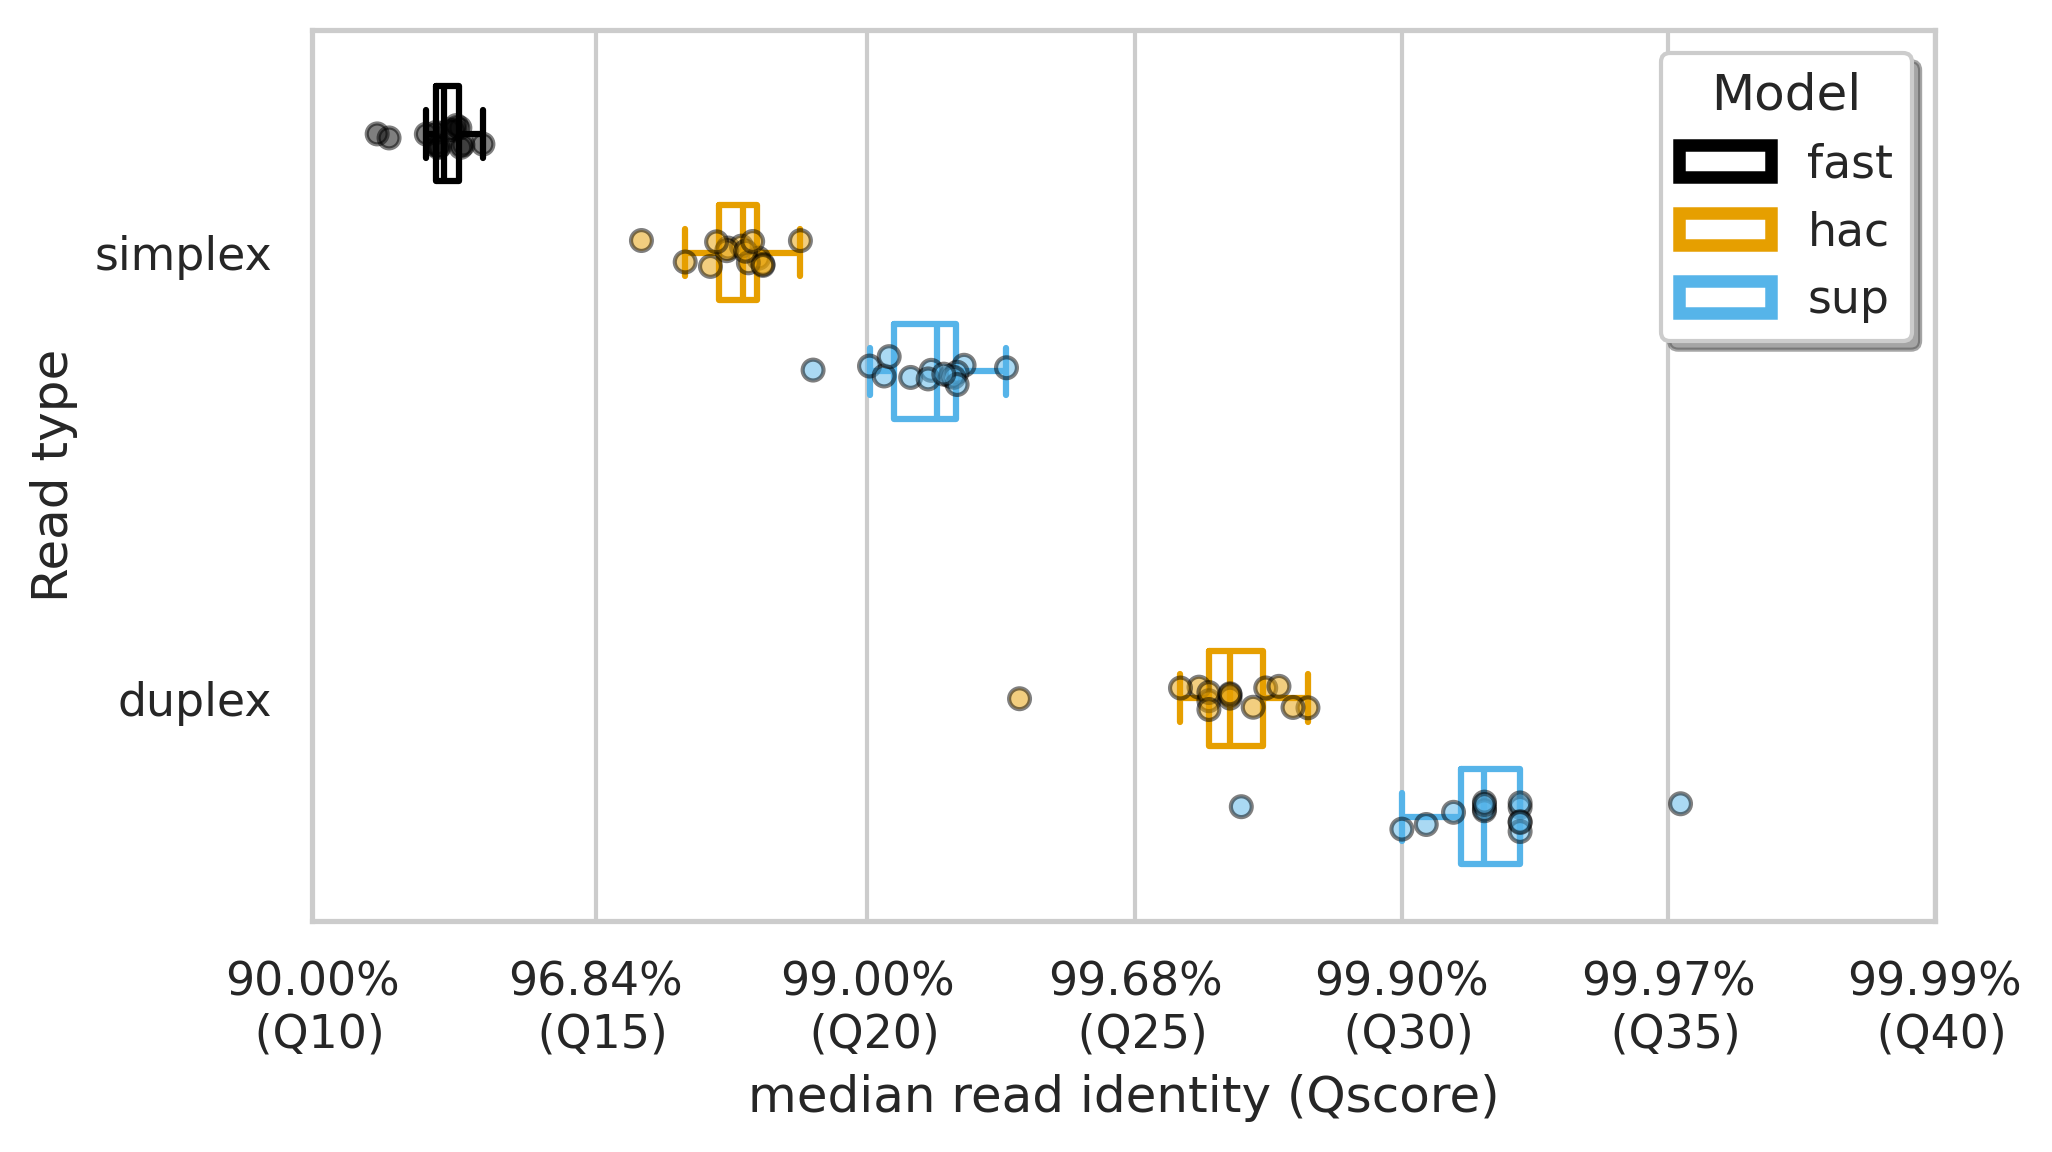

In [8]:
fig, ax = plt.subplots(1, 1, figsize=(7, 4), dpi=300, sharex=False, sharey=True)
palette = cud(n=len(df["model"].unique()))
for i, x in enumerate(["median_identity"]):
    if i == 0:
        legend = "brief"
    else:
        legend = False
    # ax = axes[i]
    if x == "median_identity" and df[x].max() > 1:
        df[x] = df[x] / 100

    sns.boxplot(
        data=df,
        y="mode",
        x=x,
        hue="model",
        ax=ax,
        showfliers=False,
        fill=None,
        gap=0.2,
        legend=legend,
        palette=palette,
    )
    sns.stripplot(
        data=df,
        y="mode",
        x=x,
        hue="model",
        ax=ax,
        dodge=True,
        linewidth=1,
        alpha=0.5,
        edgecolor="black",
        legend=False,
        palette=palette,
    )
    
    
    ax.set_ylabel("Read type")
    if x == "median_identity":
        ax.set_xscale("logit")
        xticks = [10, 15, 20, 25, 30, 35, 40]
        xticklabels = [f"{qscore2identity(xval):.2%}\n (Q{xval})" for xval in xticks]
        ax.set_xticks(qscore2identity(xticks))
        ax.set_xticklabels(xticklabels)
        ax.set_xlabel("median read identity (Qscore)")
        # move xticks and labels to the top
        # ax.xaxis.set_label_position("top")
        # ax.xaxis.tick_top()
    else:
        ax.set_xlabel("median length (bp)")

    if legend:
        handles, labels = ax.get_legend_handles_labels()
        for h in handles:
            h.set_linewidth(3)
        ax.legend(
            handles=handles,
            labels=labels,
            title="Model",
            framealpha=1.0,
            fancybox=True,
            shadow=True,
        )
fig.tight_layout()

In [9]:
df.groupby(["mode", "model"])["median_identity"].median()

mode     model
duplex   hac      0.99790
         sup      0.99930
simplex  fast     0.94085
         hac      0.98305
         sup      0.99260
Name: median_identity, dtype: float64

In [179]:
identity2qscore(0.9409)

12.284125191187442